
<a id='generic-programming'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Generic Programming

## Contents

- [Generic Programming](#Generic-Programming)  
  - [Overview](#Overview)  
  - [Exploring Type Trees](#Exploring-Type-Trees)  
  - [Distributions](#Distributions)  
  - [Numbers and Algebraic Structures](#Numbers-and-Algebraic-Structures)  
  - [Reals and Algebraic Structures](#Reals-and-Algebraic-Structures)  
  - [Functions, and Function-Like Types](#Functions,-and-Function-Like-Types)  
  - [Limitations of Dispatching on Abstract Types](#Limitations-of-Dispatching-on-Abstract-Types)  

> I find OOP methodologically wrong. It starts with classes. It is as if mathematicians would start with axioms. You do not start with axioms - you start with proofs. Only when you have found a bunch of related proofs, can you come up with axioms. You end with axioms. The same thing is true in programming: you have to start with interesting algorithms. Only when you understand them well, can you come up with an interface that will let them work. – Alexander Stepanov

## Overview

In this lecture we delve more deeply into the structure of Julia, and in particular into

- abstract and concrete types  
- the type tree  
- designing and using generic interfaces  
- the role of generic interfaces in Julia performance  


Understanding them will help you

- form a “mental model” of the Julia language  
- design code that matches the “white-board” mathematics  
- create code that can use (and be used by) a variety of other packages  
- write “well organized” Julia code that’s easy to read, modify, maintain and debug  
- improve the speed at which your code runs  


(Special thank you to Jeffrey Sarnoff)

### Generic Programming is an Attitude

From *Mathematics to Generic Programming* [[SR14]](zreferences.html#stepanov-mathematics-2014)

> Generic programming is an approach to programming that focuses on designing algorithms and data structures so that they work in the most general setting without loss of efficiency… Generic programming is more of an *attitude* toward programming than a particular set of tools.


In that sense, it is important to think of generic programming as an interactive approach to uncover generality without compromising performance rather than as a set of rules

As we will see, the core approach is to treat data structures and algorithms as loosely coupled, and is in direct contrast to the [is-a](https://en.wikipedia.org/wiki/Is-a)  approach of object-oriented programming

This lecture has the dual role of giving an introduction into the design of generic algorithms and describing how Julia helps make that possible

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.8");

-#O#- #   #                                                                    


Instantiating /home/jovyan/work/_build/jupyter/executed/more_julia/.projects/QuantEconLecturePackages-v0.9.8
  Updating

 registry at `/opt/julia/registries/General`
  Updating

 git-repo `https://github.com/JuliaRegistries/General.git`


Precompiling project...


In [2]:
using LinearAlgebra, Statistics, Compat
using Distributions, Plots, QuadGK, Polynomials, Interpolations

## Exploring Type Trees

The connection between data structures and the algorithms which operate on them is handled by the type system

Concrete types (i.e., `Float64` or `Array{Float64, 2}`) are the data structures we apply an algorithm to, and the abstract types (e.g. the corresponding `Number` and `AbstractArray`) provide the mapping between a set of related data structures and algorithms

In [3]:
using Distributions
x = 1
y = Normal()
z = "foo"
@show x, y, z
@show typeof(x), typeof(y), typeof(z)
@show supertype(typeof(x))

# pipe operator, |>, is is equivalent
@show typeof(x) |> supertype
@show supertype(typeof(y))
@show typeof(z) |> supertype
@show typeof(x) <: Any;

(x, y, z) = (1, Normal{Float64}(μ=0.0, σ=1.0), "foo")
(typeof(x), typeof(y), typeof(z)) = 

(Int64, Normal{Float64}, String)
supertype(typeof(x)) = Signed
typeof(x) |> supertype = Signed
supertype(typeof(y)) = Distribution{Univariate,Continuous}
typeof(z) |> supertype = AbstractString
typeof(x) <: Any = true

Beyond the `typeof` and `supertype` functions, a few other useful tools for analyzing the tree of types are discussed in the [introduction to types lecture](getting_started_julia/introduction_to_types.html)

In [4]:
using Base: show_supertypes # import the function from the `Base` package

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [5]:
subtypes(Integer)

3-element Array{Any,1}:
 Bool    
 Signed  
 Unsigned

Using the `subtypes` function, we can write an algorithm to traverse the type tree below any time `t` – with the confidence that all types support `subtypes`

In [6]:
#  from https://github.com/JuliaLang/julia/issues/24741
function subtypetree(t, level=1, indent=4)
        if level == 1
            println(t)
        end
        for s in subtypes(t)
            println(join(fill(" ", level * indent)) * string(s))  # print type
            subtypetree(s, level+1, indent)  # recursively print the next type, indenting
        end
    end

subtypetree (generic function with 3 methods)

Applying this to `Number`, we see the tree of types currently loaded

In [7]:
subtypetree(Number) # warning: do not use this function on ``Any``!

Number


    Complex
    Real


        AbstractFloat


            BigFloat
            Float16
            Float32
            Float64
        AbstractIrrational
            Irrational
        FixedPointNumbers.FixedPoint


            FixedPointNumbers.Fixed
            FixedPointNumbers.Normed
        Integer
            Bool
            Signed


                BigInt
                Int128
                Int16
                Int32
                Int64
                Int8
            Unsigned


                UInt128
                UInt16
                UInt32
                UInt64
                UInt8
        Rational
        Ratios.SimpleRatio


For the most part, all of the “leaves” will be concrete types

### Any

At the root of all types is `Any`

There are a few functions that work in the “most generalized” context: usable with anything that you can construct or access from other packages

We have already called `typeof`, `show` and `supertype` – which will apply to a custom `struct` type since `MyType <: Any`

In [8]:
# custom type
struct MyType
    a::Float64
end

myval = MyType(2.0)
@show myval
@show typeof(myval)
@show supertype(typeof(myval))
@show typeof(myval) <: Any;

myval = MyType(2.0)
typeof(myval) = MyType
supertype(typeof(myval)) = Any
typeof(myval) <: Any = true


Here we see another example of generic programming: every type `<: Any` supports the `@show` macro, which in turn, relies on the `show` function

The `@show` macro (1) prints the expression as a string; (2) evaluates the expression; and (3) calls the `show` function on the returned values

To see this with built-in types

In [9]:
x = [1, 2]
show(x)

[1, 2]

The `Any` type is useful, because it provides a fall-back implementation for a variety of functions

Hence, calling `show` on our custom type dispatches to the fallback function

In [10]:
myval = MyType(2.0)
show(myval)

MyType(2.0)

The default fallback implementation used by Julia would be roughly equivalent to

```julia
function show(io::IO, x)
    str = string(x)
    print(io, str)
end
```


To implement a specialized implementation of the `show` function for our type, rather than using this fallback

In [11]:
import Base.show  # to extend an existing function

function show(io::IO, x::MyType)
    str = "(MyType.a = $(x.a))"  # custom display
    print(io, str)
end
show(myval)  # it creates an IO value first and then calls the above show

(MyType.a = 2.0)

At that point, we can use the `@show` macro, which in turn calls `show`

In [12]:
@show myval;

myval = (MyType.a = 2.0)


Here we see another example of generic programming: any type with a `show` function works with `@show`

Layering of functions (e.g. `@show` calling `show`) with a “fallback” implementation makes it possible for new types to be designed and only specialized where necessary

### Unlearning Object Oriented (OO) Programming (Advanced)

See [Types](https://docs.julialang.org/en/v1/manual/types/#man-types-1) for more on OO vs. generic types

If you have never used programming languages such as C++, Java, and Python, then the type hierarchies above may seem unfamiliar and abstract

In that case, keep an open mind that this discussion of abstract concepts will have practical consequences, but there is no need to read this section

Otherwise, if you have used object-oriented programming (OOP) in those languages, then some of the concepts in these lecture notes will appear familiar

**Don’t be fooled!**

The superficial similarity can lead to misuse: types are *not* classes with poor encapsulation, and methods are *not* the equivalent to member functions with the order of arguments swapped

In particular, previous OO knowledge often leads people to write Julia code such as

In [13]:
# BAD! Replicating an OO design in Julia
mutable struct MyModel
    a::Float64
    b::Float64
    algorithmcalculation::Float64

    MyModel(a, b) = new(a, b, 0.0) # an inner constructor
end

function myalgorithm!(m::MyModel, x)
    m.algorithmcalculation = m.a + m.b + x # some algorithm
end

function set_a!(m::MyModel, a)
    m.a = a
end

m = MyModel(2.0, 3.0)
x = 0.1
set_a!(m, 4.1)
myalgorithm!(m, x)
@show m.algorithmcalculation;

m.algorithmcalculation = 7.199999999999999


You may think to yourself that the above code is similar to OO, except that you
* reverse the first argument, i.e., `myalgorithm!(m, x)` instead of the object-oriented `m.myalgorithm!(x)`
* cannot control encapsulation of the fields `a`, `b`, but you can add getter/setters like `set_a`
* do not have concrete inheritance

While this sort of programming is possible, it is (verbosely) missing the point of Julia and the power of generic programming

When programming in Julia

> - there is no [encapsulation](https://en.wikipedia.org/wiki/Encapsulation_%28computer_programming%29) and most custom types you create will be immutable  
- [Polymorphism](https://en.wikipedia.org/wiki/Polymorphism_%28computer_science%29) is achieved without anything resembling OOP [inheritance](https://en.wikipedia.org/wiki/Inheritance_%28object-oriented_programming%29)  
- [Abstraction](https://en.wikipedia.org/wiki/Abstraction_%28computer_science%29#Abstraction_in_object_oriented_programming) is implemented by keeping the data and algorithms that operate on them as orthogonal as possible – in direct contrast to OOP’s association of algorithms and methods directly with a type in a tree  
- The supertypes in Julia are simply used for selecting which specialized algorithm to use (i.e., part of generic polymorphism) and have nothing to do with OO inheritance  
- The looseness that accompanies keeping algorithms and data structures as orthogonal as possible makes it easier to discover commonality in the design  

#### Iterative Design of Abstractions

As its essence, the design of generic software is that you will start with creating algorithms which are largely orthogonal to concrete types

In the process, you will discover commonality which leads to abstract types with informally defined functions operating on them

Given the abstract types and commonality, you then refine the algorithms as they are more limited or more general than you initially thought

This approach is in direct contrast to object-oriented design and analysis ([OOAD](https://en.wikipedia.org/wiki/Object-oriented_analysis_and_design))

With that, where you specify a taxonomies of types, add operations to those types, and then move down to various levels of specialization (where algorithms are embedded at points within the taxonomy, and potentially specialized with inheritance)

In the examples that follow, we will show for exposition the hierarchy of types and the algorithms operating on them, but the reality is that the algorithms are often designed first, and the abstact types came later

## Distributions

First, consider working with “distributions”

Algorithms using distributions might (1) draw random numbers for Monte-Carlo methods; and (2) calculate the pdf or cdf – if it is defined

The process of using concrete distributions in these sorts of applications led
to the creation of the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package

Let’s examine the tree of types for a Normal distribution

In [14]:
using Distributions
d1 = Normal(1.0, 2.0) # an example type to explore
@show d1
show_supertypes(typeof(d1))

d1 = Normal{Float64}(μ=1.0, σ=2.0)
Normal{Float64} <: Distribution{Univariate,Continuous} <: Sampleable{Univariate,Continuous} <: Any

The `Sampleable{Univariate,Continuous}` type has a limited number of functions, chiefly the ability to draw a random number

In [15]:
@show rand(d1);

rand(d1) = 1.6288657602221326


The purpose of that abstract type is to provide an interface for drawing from a
variety of distributions, some of which may not have a well-defined predefined pdf

If you were writing a function to simulate a stochastic process with arbitrary
iid shocks, where you did not need to assume an existing pdf etc., this is a natural candidate

For example, to simulate $ x_{t+1} = a x_t + b \epsilon_{t+1} $ where
$ \epsilon \sim D $ for some $ D $, which allows drawing random values

In [16]:
function simulateprocess(x₀; a = 1.0, b = 1.0, N = 5, d::Sampleable{Univariate,Continuous})
    x = zeros(typeof(x₀), N+1) # preallocate vector, careful on the type
    x[1] = x₀
    for t in 2:N+1
        x[t] = a * x[t-1] + b * rand(d) # draw
    end
    return x
end
@show simulateprocess(0.0, d=Normal(0.2, 2.0));

simulateprocess(0.0, d=Normal(0.2, 2.0)) = [0.0, -1.70654, -0.571571, -2.28534, 2.35964, 4.48561]


The `Sampleable{Univariate,Continuous}` and, especially, the `Sampleable{Multivariate,Continuous}` abstract types are useful generic interfaces for Monte-Carlo and Bayesian methods

Moving down the tree, the `Distributions{Univariate, Continuous}` abstract type has other functions we can use for generic algorithms operating on distributions

These match the mathematics, such as `pdf`, `cdf`, `quantile`, `support`, `minimum`, `maximum`, etc.

In [17]:
d1 = Normal(1.0, 2.0)
d2 = Exponential(0.1)
@show d1
@show d2
@show supertype(typeof(d1))
@show supertype(typeof(d2))

@show pdf(d1, 0.1)
@show pdf(d2, 0.1)
@show cdf(d1, 0.1)
@show cdf(d2, 0.1)
@show support(d1)
@show support(d2)
@show minimum(d1)
@show minimum(d2)
@show maximum(d1)
@show maximum(d2);

d1 = Normal{Float64}(μ=1.0, σ=2.0)
d2 = 

Exponential{Float64}(θ=0.1)
supertype(typeof(d1)) = Distribution{Univariate,Continuous}
supertype(typeof(d2)) = Distribution{Univariate,Continuous}
pdf(d1, 0.1) = 0.18026348123082397
pdf(d2, 0.1) = 3.6787944117144233
cdf(d1, 0.1) = 0.32635522028792
cdf(d2, 0.1) = 0.6321205588285577


support(d1) = RealInterval(-Inf, Inf)
support(d2) = RealInterval(0.0, Inf)
minimum(d1) = -Inf
minimum(d2) = 0.0
maximum(d1) = Inf
maximum(d2) = Inf


You could create your own `Distributions{Univariate, Continuous}` type by implementing those functions – as is described in [the documentation](https://juliastats.github.io/Distributions.jl/latest/extends.html)

If you fulfill all of the conditions of a particular interface, you can use algorithms from the present, past, and future  that are written for the abstract `Distributions{Univariate, Continuous}` type

As an example, consider the [StatsPlots](https://github.com/JuliaPlots/StatsPlots.jl) package

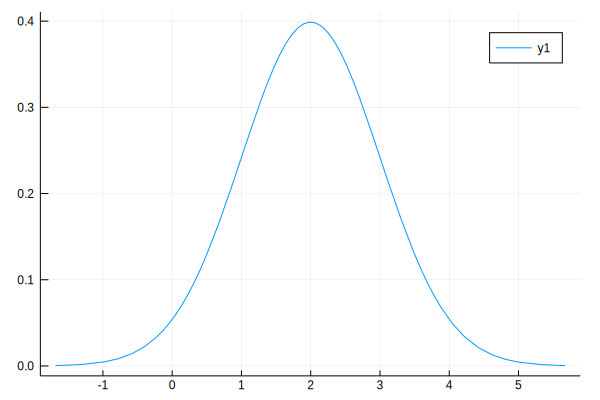

In [18]:
using StatsPlots
d = Normal(2.0, 1.0)
plot(d) # note no other arguments!

Calling `plot` on any subtype of `Distributions{Univariate, Continuous}`
displays the `pdf` and uses `minimum` and `maximum` to determine the range

Let’s create our own distribution type

In [19]:
struct OurTruncatedExponential <: Distribution{Univariate,Continuous}
    α::Float64
    xmax::Float64
end
Distributions.pdf(d::OurTruncatedExponential, x) = d.α *exp(-d.α * x)/exp(-d.α * d.xmax)
Distributions.minimum(d::OurTruncatedExponential) = 0
Distributions.maximum(d::OurTruncatedExponential) = d.xmax
# ... more to have a complete type

To demonstrate this

In [20]:
d = OurTruncatedExponential(1.0,2.0)
@show minimum(d), maximum(d)
@show support(d) # why does this work?

(minimum(d), maximum(d)) = (0, 2.0)
support(d) = 

RealInterval(0.0, 2.0)


RealInterval(0.0, 2.0)

Curiously, you will note that the `support` function works, even though we did not provide one

This is another example of the power of multiple dispatch and generic programming

In the background, the `Distributions.jl` package  has something like the following implemented

```julia
    Distributions.support(d::Distribution) = RealInterval(minimum(d), maximum(d))
```


Since `OurTruncatedExponential <: Distribution`, and we
implemented `minimum` and `maximum`, calls to `support` get this
implementation as a fallback

These functions are enough to use the  `StatsPlots.jl` package

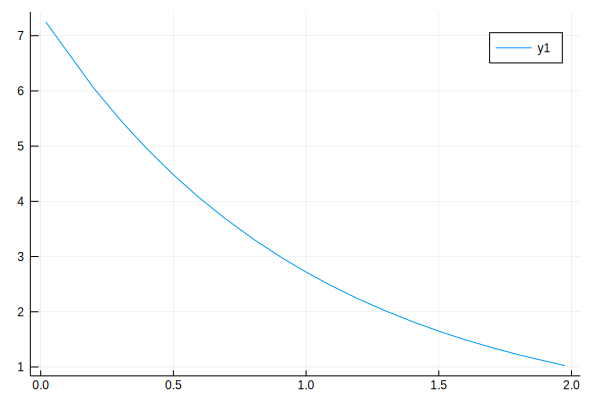

In [21]:
plot(d) # uses the generic code!

A few things to point out

- Even if it worked for `StatsPlots`, our implementation is incomplete, as we haven’t fulfilled all of the requirements of a `Distribution`  
- We also did not implement the `rand` function, which means we are breaking the implicit contract of the `Sampleable` abstract type  
- It turns out that there is a better way to do this precise thing already built into `Distributions`  

typeof(d) = Truncated{Exponential{Float64},Continuous}


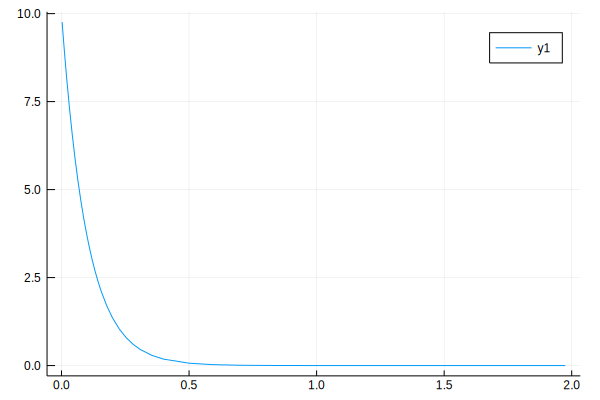

In [22]:
d = Truncated(Exponential(0.1), 0.0, 2.0)
@show typeof(d)
plot(d)

This is the power of generic programming in general, and Julia in particular: you can combine and compose completely separate packages and code, as long as there is an agreement on abstract types and functions

## Numbers and Algebraic Structures

Define two binary functions,  $ + $ and $ \cdot $, called addition and multiplication – although the operators can be applied to data structures much more abstract than a `Real`

In mathematics, a [ring](https://en.wikipedia.org/wiki/Ring_%28mathematics%29) is a set with associated additive and multiplicative operators where

> - the additive operator is associative and commutative  
- the multiplicative operator is associative and distributive with respect to the additive operator  
- there is an additive identity element,  denoted $ 0 $, such that $ a + 0 = a $ for any $ a $ in the set  
- there is an additive inverse of each element, denoted $ -a $, such that $ a + (-a) = 0 $  
- there is a multiplicative identity element, denoted $ 1 $, such that $ a \cdot 1 = a = 1 \cdot a $  
- a total or partial ordering is **not** required (i.e., there does not need to be any meaningful $ < $ operator defined)  
- a multiplicative inverse is **not** required  



While this skips over some parts of the mathematical definition, this algebraic structure provides motivation for the abstract `Number` type in Julia

> - **Remark:** We use the term “motivation” because they are not formally connected and the mapping is imperfect  
- The main difficulty when dealing with numbers that can be concretely created on a computer is that the requirement that the operators are closed in the set are difficult to ensure (e.g. floating points have finite numbers of bits of information)  



Let `typeof(a) = typeof(b) = T <: Number`, then under an informal definition of the **generic interface** for
`Number`, the following must be defined

> - the additive operator: `a + b`  
- the multiplicative operator: `a * b`  
- an additive inverse operator: `-a`  
- an inverse operation for addition `a - b = a + (-b)`  
- an additive identity: `zero(T)` or `zero(a)` for convenience  
- a multiplicative identity: `one(T)` or `one(a)` for convenience  



The core of generic programming is that, given the knowledge that a value is of type `Number`, we can design algorithms using any of these functions and not concern ourselves with the particular concrete type

Furthermore, that generality in designing algorithms comes with no compromises on performance compared to carefully designed algorithms written for that particular type

To demonstrate this for a complex number, where `Complex{Float64} <: Number`

In [23]:
a = 1.0 + 1.0im
b = 0.0 + 2.0im
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = Complex{Float64}
typeof(a) <: Number = true


a + b = 1.0 + 3.0im
a * b = -2.0 + 2.0im
-a = -1.0 - 1.0im
a - b = 1.0 - 1.0im
zero(a) = 0.0 + 0.0im
one(a) = 1.0 + 0.0im


And for an arbitrary precision integer where `BigInt <: Number`
(i.e., a different type than the `Int64` you have worked with, but nevertheless a `Number`)

In [24]:
a = BigInt(10)
b = BigInt(4)
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = BigInt
typeof(a) <: Number = true


a + b = 14
a * b = 40
-a = -10
a - b = 6
zero(a) = 0
one(a) = 1


### Complex Numbers and Composition of Generic Functions

This allows us to showcase further how different generic packages compose – even if they are only loosely coupled through agreement on common generic interfaces

The `Complex` numbers require some sort of storage for their underlying real and imaginary parts, which is itself left generic

This data structure is defined to work with any type `<: Number`, and is parameterized (e.g. `Complex{Float64}` is a complex number storing the imaginary and real parts in `Float64`)

In [25]:
x = 4.0 + 1.0im
@show x, typeof(x)

xbig = BigFloat(4.0) + 1.0im
@show xbig, typeof(xbig);

(x, typeof(x)) = (4.0 + 1.0im, Complex{Float64})
(xbig, typeof(xbig)) = 

(4.0 + 1.0im, Complex{BigFloat})


The implementation of the `Complex` numbers use the underlying operations of
storage type, so as long as `+`, `*` etc. are defined – as they should be
for any `Number` – the complex operation can be defined

In [26]:
@which +(x,x)

+(z::Complex, w::Complex) in Base at complex.jl:266

Following that link, the implementation of `+` for complex numbers is

```julia
+(z::Complex, w::Complex) = Complex(real(z) + real(w), imag(z) + imag(w))
```


`real(z)` and `imag(z)` returns the associated components of the complex number in the underlying storage type (e.g. `Float64` or `BigFloat`)

The rest of the function has been carefully written to use functions defined for any `Number` (e.g. `+` but not `<`, since it is not part of the generic number interface)

To follow another example , look at the implementation of `abs` specialized for complex numbers

In [27]:
@which abs(x)

abs(z::Complex) in Base at complex.jl:260

The source is

```julia
abs(z::Complex)  = hypot(real(z), imag(z))
```


In this case, if you look at the generic function to get the hypotenuse, `hypot`, you will see that it has the function signature `hypot(x::T, y::T) where T<:Number`, and hence works for any `Number`

That function, in turn, relies on the underlying `abs` for the type of `real(z)`

This would dispatch to the appropriate `abs` for the type

In [28]:
@which abs(1.0)

abs(x::Float64) in Base at float.jl:522

In [29]:
@which abs(BigFloat(1.0))

abs(x::Real) in Base at number.jl:144

With implementations

```julia
abs(x::Real) = ifelse(signbit(x), -x, x)
abs(x::Float64) = abs_float(x)
```


For a `Real` number (which we will discuss in the next section) the fallback implementation calls a function `signbit` to determine if it should flip the sign of the number

The specialized version for `Float64 <: Real` calls a function called `abs_float` – which turns out to be a specialized implementation at the compiler level

While we have not completely dissected the tree of function calls, at the bottom of the tree you will end at the most optimized version of the function for the underlying datatype

Hopefully this showcases the power of generic programming:  with a well-designed set of abstract types and functions, the code can both be highly general and composable and still use the most efficient implementation possible

## Reals and Algebraic Structures

Thinking back to the mathematical motivation, a [field](https://en.wikipedia.org/wiki/Field_%28mathematics%29) is a `ring` with a few additional properties, among them

> - a multiplicative inverse: $ a^{-1} $  
- an inverse operation for multiplication: $ a / b = a \cdot b^{-1} $  



Furthermore, we will make it a [total ordered](https://en.wikipedia.org/wiki/Total_order#Strict_total_order) field with

> - a total ordering binary operator: $ a < b $  



This type gives some motivation for the operations and properties of the `Real` type

Of course, `Complex{Float64} <: Number` but not `Real` – since the ordering is not defined for complex numbers in mathematics

These operations are implemented in any subtype of `Real` through

> - the multiplicative inverse: `inv(a)`  
- the multiplicative inverse operation: `a / b = a * inv(b)`  
- an ordering `a < b`  



We have already shown these with the `Float64` and `BigFloat`

To show this for the `Rational` number type, where `a // b` constructs a rational number $ \frac{a}{b} $

In [30]:
a = 1 // 10
b = 4 // 6
@show typeof(a)
@show typeof(a) <: Number
@show typeof(a) <: Real
@show inv(a)
@show a / b
@show a < b;

typeof(a) = Rational{Int64}
typeof(a) <: Number = true
typeof(a) <: Real = true
inv(a) = 10//1
a / b = 3//20
a < b = true


**Remark:** Here we see where and how the precise connection to the mathematics for number types breaks down for practical reasons, in particular

> - `Integer` types (i.e., `Int64 <: Integer`) do not have a a multiplicative inverse with closure in the set  
- However, it is necessary in practice for integer division to be defined, and return back a member of the `Real`’s  
- This is called [type promotion](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1), where a type can be converted to another to ensure an operation is possible by direct conversion between types (i.e., it can be independent of the type hierarchy)  



Do not think of the break in the connection between the underlying algebraic structures and the code as a failure of the language or design

Rather, the underlying algorithms for use on a computer do not perfectly fit the algebraic structures in this instance

Moving further down the tree of types provides more operations more directly tied to the computational implementation than abstract algebra

For example, floating point numbers have a machine precision, below which numbers become indistinguishable due to lack of sufficient “bits” of information

In [31]:
@show Float64 <: AbstractFloat
@show BigFloat <: AbstractFloat
@show eps(Float64)
@show eps(BigFloat);

Float64 <: AbstractFloat = true
BigFloat <: AbstractFloat = true
eps(Float64) = 2.220446049250313e-16
eps(BigFloat) = 

1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77


The `isless` function also has multiple methods

First let’s try with integers

In [32]:
@which isless(1, 2)

isless(x::Real, y::Real) in Base at operators.jl:338

As we saw previously, the `Real` data type is an *abstract* type, and encompasses both floats and integers

If we go to the provided link in the source, we see the entirety of the function is

```julia
isless(x::Real, y::Real) = x<y
```


That is, for any values where `typeof(x) <: Real` and `typeof(y) <: Real`, the definition relies on `<`

We know that `<` is defined for the types because it is part of the informal interface for the `Real` abstract type

Note that this is not defined for `Number` because not all `Number` types have the `<` ordering operator defined (e.g. `Complex`)

In order to generate fast code, the implementation details may define specialized versions of these operations

In [33]:
isless(1.0, 2.0)  # applied to two floats
@which isless(1.0, 2.0)

isless(x::Float64, y::Float64) in Base at float.jl:459

Note that the reason  `Float64 <: Real` calls this implementation rather than the one given above, is that `Float64 <: Real`, and Julia chooses the most specialized implementation for each function

The specialized implementations are often more subtle than you may realize due to [floating point arithmetic](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html), [underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow), etc.

## Functions, and Function-Like Types

Another common example of the separation between data structures and algorithms is the use of functions

Syntactically, a univariate “function” is any `f` that can call an argument `x` as `f(x)`

For example, we can use a standard function

quadgk(f, 0.0, 1.0) = (0.3333333333333333, 5.551115123125783e-17)


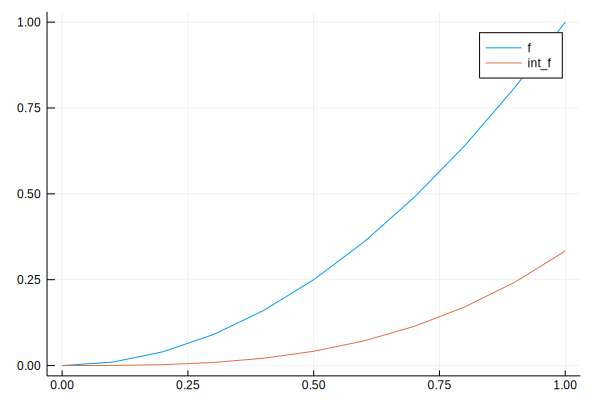

In [34]:
using QuadGK
f(x) = x^2
@show quadgk(f, 0.0, 1.0)  # integral

function plotfunctions(f)
    intf(x) = quadgk(f, 0.0, x)[1]  # int_0^x f(x) dx

    x = 0:0.1:1.0
    f_x = f.(x)
    plot(x, f_x, label="f")
    plot!(x, intf.(x), label="int_f")
end
plotfunctions(f)  # call with our f

Of course, univariate polynomials are another type of univariate function

p = Poly(2 - 5*x + 2*x^2)
p(1.0) = -1.0


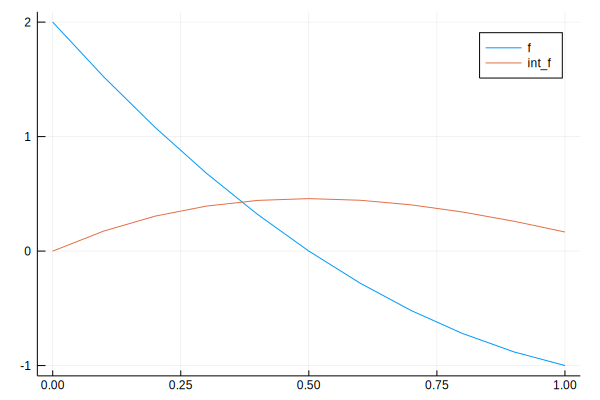

In [35]:
using Polynomials
p = Poly([2, -5, 2], :x)  # :x just gives a symbol for display
@show p
@show p(1.0) # call like a function

plotfunctions(p)  # same generic function

Similarly, the result of interpolating data is also a function

f_int(1.0) = 1.0


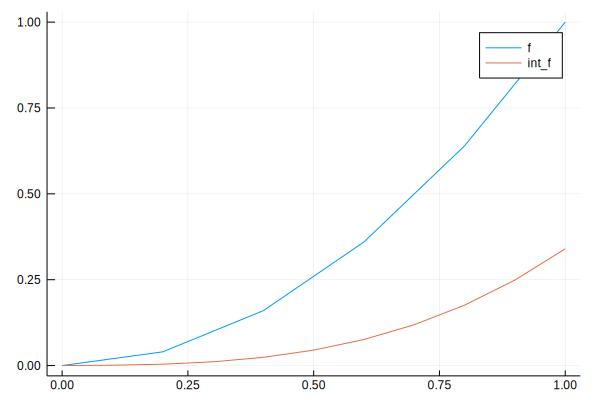

In [36]:
using Interpolations
x = 0.0:0.2:1.0
f(x) = x^2
f_int = LinearInterpolation(x, f.(x))  # interpolates the coarse grid
@show f_int(1.0)  # call like a function

plotfunctions(f_int)  # same generic function

Note that the same generic `plotfunctions` could use any variable passed to it that “looks” like a function, i.e., can call `f(x)`

This approach to design with types – generic, but without any specific type declarations – is called [duck typing](https://en.wikipedia.org/wiki/Duck_typing)

If you need to make an existing type callable, see [Function Like Objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1)

## Limitations of Dispatching on Abstract Types

You will notice that types in Julia represent a tree with `Any` at the root

The tree structure has worked well for the above examples, but it doesn’t allow us to associate multiple categorizations of types

For example, a semi-group type would be useful for a writing generic code (e.g.
continuous-time solutions for ODEs and matrix-free methods), but cannot be
implemented rigorously since the `Matrix` type is a semi-group as well
as an `AbstractArray`, but not all semi-groups are `AbstractArray` s

The main way to implement this in a generic language is with a design approach called “traits”

- See the [original discussion](https://github.com/JuliaLang/julia/issues/2345#issuecomment-54537633) and an [example of a package to facilitate the pattern](https://github.com/mauro3/SimpleTraits.jl)  
- A complete description of the traits pattern as the natural evolution of Multiple Dispatch is given in this [blog post](https://white.ucc.asn.au/2018/10/03/Dispatch,-Traits-and-Metaprogramming-Over-Reflection.html)  